# Projeto 1 - Fundamentos de Sistemas Inteligentes
**Aluno:** Kallebe de Sousa Silva

**Matrícula:** 18/0053485

## Inicialização
Primeiramente será feita a importação das bibliotecas que serão utilizadas e a leitura do arquivo de referência.

In [1]:
import matplotlib.pyplot  as plt
import numpy              as np
import pandas             as pd

from sklearn.ensemble           import RandomForestClassifier
from sklearn.metrics            import ConfusionMatrixDisplay
from sklearn.metrics            import roc_auc_score
from sklearn.metrics            import roc_curve
from sklearn.model_selection    import StratifiedKFold
from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import LabelEncoder
from sklearn.tree               import DecisionTreeClassifier

# Lê o arquivo de dados
dataset = pd.read_csv('./SA_heart.csv', index_col='id')

label_col = 'chd'
data      = dataset.drop(label_col, axis=1)

# Codifica coluna 'famhist' para valores numéricos
le = LabelEncoder()
data['famhist'] = le.fit_transform(data['famhist'])

## Análise inicial dos dados
Plotando a estatística inicial do dataset.

sbp             AxesSubplot(0.125,0.657941;0.227941x0.222059)
tobacco      AxesSubplot(0.398529,0.657941;0.227941x0.222059)
ldl          AxesSubplot(0.672059,0.657941;0.227941x0.222059)
adiposity       AxesSubplot(0.125,0.391471;0.227941x0.222059)
famhist      AxesSubplot(0.398529,0.391471;0.227941x0.222059)
typea        AxesSubplot(0.672059,0.391471;0.227941x0.222059)
obesity            AxesSubplot(0.125,0.125;0.227941x0.222059)
alcohol         AxesSubplot(0.398529,0.125;0.227941x0.222059)
age             AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

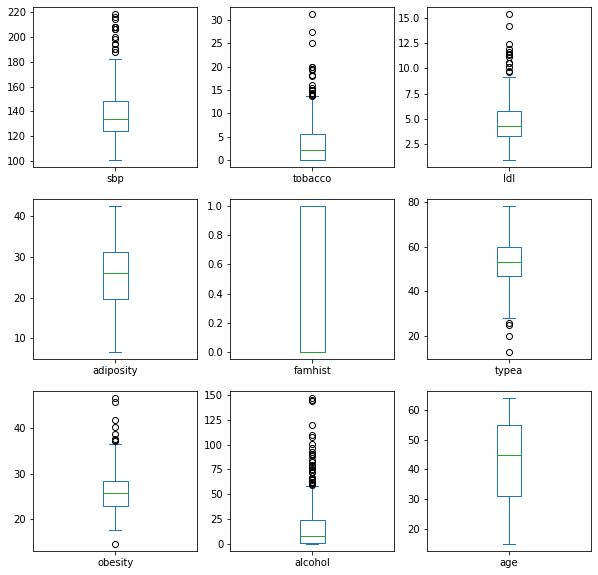

In [2]:
data.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,10))

## Árvore de decisão
Será utilizado o algoritmo CART (Classification And Regression Trees) para construir um modelo para o dataset de referência.

90% do dataset será utilizado para o treinament do modelo, enquanto 10% será reservado para teste.

In [3]:
x_train, x_test, y_train, y_test = train_test_split(data, dataset[label_col], test_size=0.1, random_state=42)

dt_classifier = DecisionTreeClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

false_true_positives = []
for train, test in kfold.split(x_train, y_train):
  dt_classifier.fit(x_train.iloc[train], y_train.iloc[train])
  
  y_pred                  = dt_classifier.predict_proba(x_train.iloc[test])[:, 1]
  false_pos, true_pos, _  = roc_curve(y_train.iloc[test], y_pred)
  auc                     = roc_auc_score(y_train.iloc[test], y_pred)

  false_true_positives.append((false_pos, true_pos, auc))

Para analisar o desempenho do modelo criado, foram plotadas a Curva ROC para cada iteração do processo de validação cruzada, assim como a Matriz de Confusão, utilizando os dados de teste.

In [4]:
def plot_roc_e_matriz_confusao(false_true_positives, model, x_test, y_test):
  # Curva ROC
  # Configuração da plotagem
  plt.figure(figsize=(8,8))
  plt.axes().set_aspect('equal')
  plt.plot([0, 1], [0, 1], 'b', linestyle='--')
  plt.title('Curva ROC')
  plt.xlabel('Taxa de Falsos Positivos')
  plt.ylabel('Taxa de Verdadeiros Positivos')

  for fp, tp, auc in false_true_positives:
    plt.plot(fp, tp, label='AUC='+"{:.4f}".format(auc), alpha=0.3)

  plt.legend()
  plt.show()

  # Matriz de confusão
  ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, normalize='all', cmap='Purples')
  plt.title('Matriz de Confusão')
  plt.show()

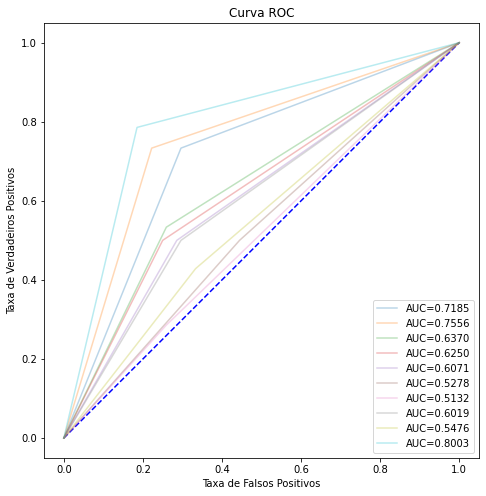

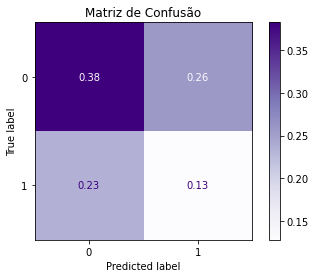

In [5]:
plot_roc_e_matriz_confusao(false_true_positives, dt_classifier, x_test, y_test)

## Floresta Randômica

Em seguida, foi utilizado o classificador de Floresta Randômica para treinar e estimar os dados do dataset, ainda utilizando 10% dos dados para teste e validação cruzada com 10 rodadas.

In [6]:
forest_classifier = RandomForestClassifier(n_estimators=100, max_features=9)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

false_true_positives = []
for train, test in kfold.split(x_train, y_train):
  forest_classifier.fit(x_train.iloc[train], y_train.iloc[train])
  
  y_pred                  = forest_classifier.predict_proba(x_train.iloc[test])[:, 1]
  false_pos, true_pos, _  = roc_curve(y_train.iloc[test], y_pred)
  auc                     = roc_auc_score(y_train.iloc[test], y_pred)

  false_true_positives.append((false_pos, true_pos, auc))

Após fazer as predições para o modelo de Floresta Randômica, foram gerados os gráficos da Curva ROC, com as medidas AUC ROC, e a Matriz de Confusão.

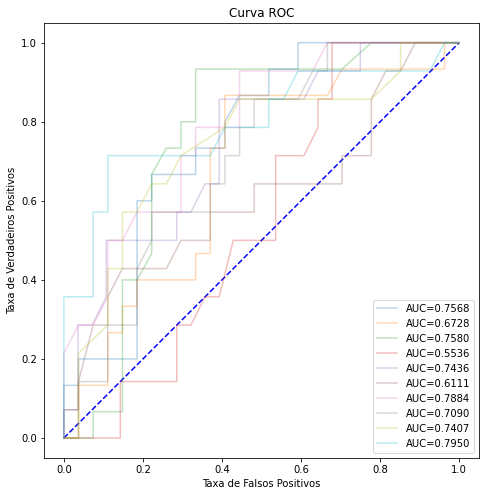

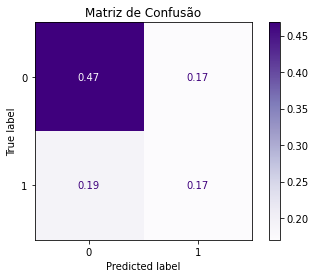

In [7]:
plot_roc_e_matriz_confusao(false_true_positives, forest_classifier, x_test, y_test)

Abaixo foi construído outro modelo para Floresta Randômica, desta vez utilizando a raiz quadrada das variáveis preditoras: m = √9 = 3.

O código também armazena a importância das variáveis preditores do melhor resultado (utilizando o parâmetro AUC), que será avaliado posteriormente.

In [8]:
forest_classifier = RandomForestClassifier(n_estimators=100, max_features='sqrt')
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

false_true_positives = []

feature_importances = []
melhor_auc          = 0

for train, test in kfold.split(x_train, y_train):
  forest_classifier.fit(x_train.iloc[train], y_train.iloc[train])
  
  y_pred                  = forest_classifier.predict_proba(x_train.iloc[test])[:, 1]
  false_pos, true_pos, _  = roc_curve(y_train.iloc[test], y_pred)
  auc                     = roc_auc_score(y_train.iloc[test], y_pred)

  false_true_positives.append((false_pos, true_pos, auc))

  if auc > melhor_auc:
    melhor_auc = auc
    feature_importances = forest_classifier.feature_importances_

Gerando os gráficos da Curva ROC, com as medidas AUC ROC, e a Matriz de Confusão:

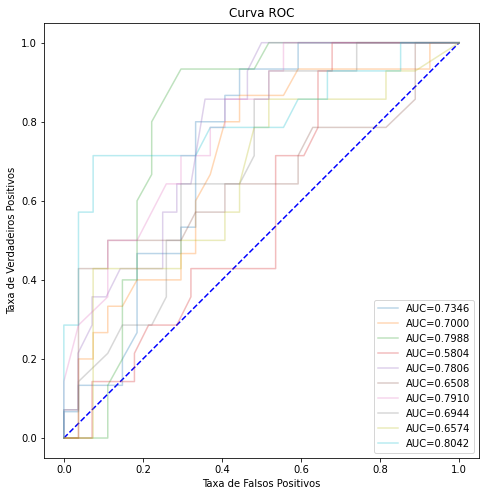

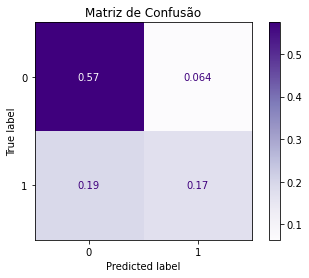

In [9]:
plot_roc_e_matriz_confusao(false_true_positives, forest_classifier, x_test, y_test)

Em seguida, foi plotado os valores das importâncias das variáveis preditoras para o melhor resultado do processo de validação cruzada no modelo de Florestas Randômicas.

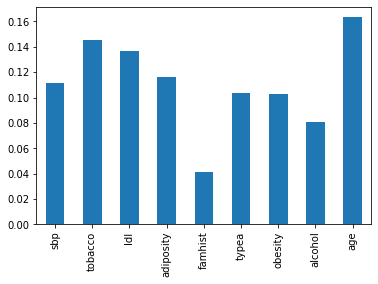

In [10]:
importances = pd.Series(feature_importances, index=x_train.columns)
importances.plot.bar()
plt.show()


Avaliando o gráfico, nota-se que as variáveis mais relevantes para este dataset foram:

In [11]:
f_importances = feature_importances[:]

max_index = np.argmax(f_importances)
most_important = x_train.columns[max_index]

f_importances[max_index] = 0
max_index = np.argmax(f_importances)
second_most_important = x_train.columns[max_index]

print('Variáveis mais relevantes: %s e %s' % (most_important, second_most_important))

Variáveis mais relevantes: age e tobacco
